In [1]:
# The first part of the section discusses the logarithm version of the bayesian update on odds.
#
# O(H|T) = O(H) * P(T|H)/P(T|~H)
#
# or,
#
# log O(H|T) = log O(H) + log R
# where R is bayesian factor. If we see the event H several times (x), the formula would become.
#
# log O(H|T) = log O(H) + x * log R
#            = beta0 + beta1 b
#           
# Going through all the derviation, we arrive at a simple linear equation. This is the basis
# of logistic regression.
#
# The log of odd is called the logit - usually expressed as
# logit(p) = log(p/(1-p)) where p is the corresponding probability.
#
# The inverse of logit is the expit function, expit(x) = 1/(1+exp(-x)). also known as sigmoid.

In [2]:
# The O-ring failure on Challenger space shuttle. Temperature vs failure data.
import pandas as pd

# data stolen from https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb
data = pd.DataFrame([[ 66., 0.], [ 70., 1.], [ 69., 0.], [ 68., 0.], [ 67., 0.],
                     [ 72., 0.], [ 73., 0.], [ 70., 0.], [ 57., 1.], [ 63., 1.],
                     [ 70., 1.], [ 78., 0.], [ 67., 0.], [ 53., 1.], [ 67., 0.],
                     [ 75., 0.], [ 70., 0.], [ 81., 0.], [ 76., 0.], [ 79., 0.],
                     [ 75., 1.], [76., 0.], [ 58., 1.]], columns= ["Temp (F)", "Failure?"])

In [3]:
# Now let's provide specify x and y:
offset = data['Temp (F)'].mean().round()
print(offset)
data['x'] = data['Temp (F)'] - offset
data['y'] = data['Failure?']
data.head()

70.0


,Temp (F),Failure?,x,y
0,66.0,0.0,-4.0,0.0
1,70.0,1.0,0.0,1.0
2,69.0,0.0,-1.0,0.0
3,68.0,0.0,-2.0,0.0
4,67.0,0.0,-3.0,0.0


In [4]:
# Now we run a non-bayesian logistic regression to get an approximate slope and intercept.
# It will be used in generating and testing the hypothesis of the true slope and true intercept.
import statsmodels.formula.api as smf
formula = 'y ~ x'
results = smf.logit(formula, data=data).fit(disp=False)
results.params

Intercept   -1.208490
x           -0.232163
dtype: float64

In [5]:
from utils import Pmf, make_joint
import numpy as np
from scipy.special import expit

qs = np.linspace(-5, 1, 101)
prior_inter = Pmf(1, qs)
qs = np.linspace(-0.8, 0.1, 101)
prior_slope = Pmf(1, qs)
joint_prior = make_joint(prior_inter, prior_slope)
joint_prior_pmf = Pmf(joint_prior.stack())
joint_prior_pmf.head()

-0.8  -5.00    1
      -4.94    1
      -4.88    1
dtype: int64

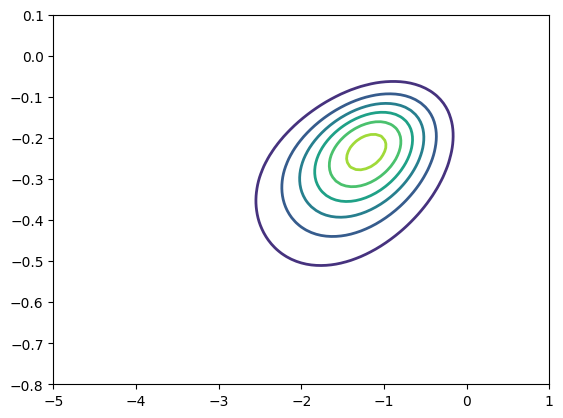

In [6]:
# Now the likelihood. The probability can be assumed to be a binomial distribution
# given the total number of o-ring and the failed o-rings. The probability of one
# o-ring failing is given by the expit function. Then the likelihood is all the
# probability mulitplied (safe to assume the events are independent).
from scipy.stats import binom

def update(prior_pmf, data):
    likelihoods = prior_pmf.astype('float64')
    temps = [v for v in data['x']]
    ks = [v for v in data['y']]
    ns = [1 for _ in data['y']]
    for slope, inter in prior_pmf.index:
        ps = expit(inter + slope * np.array(temps))
        ps2 = binom.pmf(ks, ns, ps)
        likelihoods[slope, inter] = ps2.prod()
    posterior = Pmf(prior_pmf * likelihoods)
    posterior.normalize()
    return posterior

from utils import plot_contour

joint_posterior_pmf = update(joint_prior_pmf, data)
plot_contour(joint_posterior_pmf.unstack())

Intercept    1.113137
x           -0.232163
dtype: float64


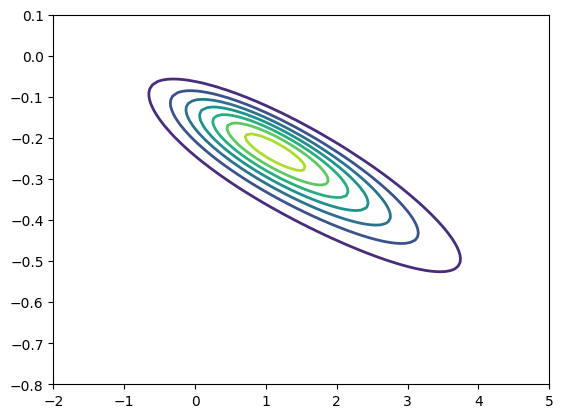

In [7]:
# exercise 16-1: set offset=60 and rerun the analysis.
def ex_16_1(data, offset, qs_inter, qs_slope):
    data['x'] = data['Temp (F)'] - offset
    data['y'] = data['Failure?']

    formula = 'y ~ x'
    results = smf.logit(formula, data=data).fit(disp=False)
    print(results.params)

    prior_inter = Pmf(1, qs_inter)
    prior_slope = Pmf(1, qs_slope)
    joint_prior = make_joint(prior_inter, prior_slope)
    joint_prior_pmf = Pmf(joint_prior.stack())
    
    joint_posterior_pmf = update(joint_prior_pmf, data)
    return joint_posterior_pmf.unstack()

joint_posterior_ex_16_1 = ex_16_1(data, 60, np.linspace(-2, 5, 101), np.linspace(-0.8, 0.1, 101))
plot_contour(joint_posterior_ex_16_1)

<Axes: >

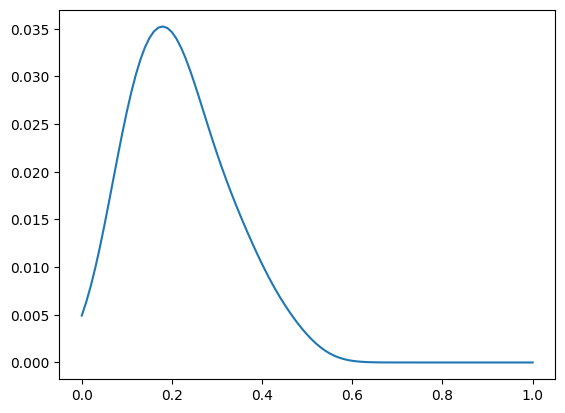

In [8]:
from scipy.stats import gaussian_kde

def prob_damage_at_temp(joint_posterior_pmf, temp, offset=70):
    samples = joint_posterior_pmf.choice(100)
    prob_data = []
    for slope, inter in samples:
        prob_data.append(expit(inter + slope * (temp - offset)))
    kde = gaussian_kde(prob_data, bw_method=0.6)
    qs = np.linspace(0, 1, 101)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf
prob_damage_at_temp(joint_posterior_pmf, 70).plot()

In [9]:
# This method of using a statsmodels to compute the parameters that maximizes the probability of the data and using Bayesian method to estimate the bound
# of the parameters is called the Empirical Bayes Method.

In [10]:
# Exercise 16-2: a political pundit claims to be able to predict the outcome of election.
# He says Alice has 70% probability beating Bob. But then Bob won. 
#
# Let H be that the pundit's algorithm is legit. Let ~H be that the pundit's algorithm bogus and
# the probability it produces are random values with a mean of 50%.
import math
# log_odd = log_prior + log_likelihood
log_legit = math.log(4)
log_legit += math.log(0.7) - math.log(0.5)
log_legit += math.log(0.3) - math.log(0.5)
log_legit += math.log(0.9) - math.log(0.5)
log_legit

1.7997276388772314